In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

In [2]:
with open('dataset_tl_1.pickle', 'rb') as f:
    (X_train_3, Y_train_3) = pickle.load(f)
print("Train shape: ")
print(X_train_3.shape)
print(Y_train_3.shape)

Train shape: 
(1061, 600, 800, 3)
(1061,)


In [5]:
X_train_1, Y_train_1 = shuffle(X_train_3, Y_train_3)
X_train_2, X_valid, Y_train_2, Y_valid = train_test_split(X_train_1, Y_train_1, test_size=0.01, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train_2, Y_train_2, test_size=0.01, random_state=42)

print("Train shape: ")
print(X_train.shape)
print("Valid shape: ")
print(X_valid.shape)
print("Test shape: ")
print(X_test.shape)
n_classes = 3
Class_names = ["RED","UNKNOWN", "GREEN"]

Train shape: 
(1039, 600, 800, 3)
Valid shape: 
(11, 600, 800, 3)
Test shape: 
(11, 600, 800, 3)


In [6]:
EPOCHS = 250
BATCH_SIZE = 64

layer1 = (5,5,3,4)
layer2 = (5,5,4,5)
layer3 = (5,5,5,6)
layer4 = (5,5,6,7)
layer5 = (5,5,7,7)
layer6 = (2058,32)
layer7 = (32,16)
layer8 = (16,n_classes)

from tensorflow.contrib.layers import flatten

mu = 0
sigma = 0.15

conv1_W = tf.Variable(tf.truncated_normal(shape=layer1, mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(layer1[3]))

conv2_W = tf.Variable(tf.truncated_normal(shape=layer2, mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(layer2[3]))

conv3_W = tf.Variable(tf.truncated_normal(shape=layer3, mean = mu, stddev = sigma))
conv3_b = tf.Variable(tf.zeros(layer3[3]))

conv4_W = tf.Variable(tf.truncated_normal(shape=layer4, mean = mu, stddev = sigma))
conv4_b = tf.Variable(tf.zeros(layer4[3]))

conv5_W = tf.Variable(tf.truncated_normal(shape=layer5, mean = mu, stddev = sigma))
conv5_b = tf.Variable(tf.zeros(layer5[3]))

fc1_W = tf.Variable(tf.truncated_normal(shape=layer6, mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(layer6[1]))

fc2_W  = tf.Variable(tf.truncated_normal(shape=layer7, mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(layer7[1]))

fc3_W  = tf.Variable(tf.truncated_normal(shape=layer8, mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(n_classes))

keep_prob = tf.placeholder("float", name = "keep_prob")

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    x_color = x[:,:,:,0:3]
    conv1 = tf.nn.conv2d(x_color, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4 = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4 = tf.nn.relu(conv4)
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv5 = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='VALID') + conv5_b
    conv5 = tf.nn.relu(conv5)
    conv5 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #fc0   = tf.concat([flatten(conv5),flatten(conv4)],1)
    fc0   = flatten(conv5)
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits
    
x = tf.placeholder(tf.float32, (None, 600, 800, 3), name = "input_image")
y = tf.placeholder(tf.int32, (None), name = "correct_class")
print(y)
one_hot_y = tf.one_hot(y, n_classes, name = "one_hot_output")

rate = 0.002
beta = 0.002

logits = LeNet(x)
output_value = tf.argmax(logits, 1, name = "output")
print(x)
print(one_hot_y)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y, name = "cross_entropy")
loss_operation = tf.reduce_mean(cross_entropy + \
    beta*tf.nn.l2_loss(conv1_W) + \
    beta*tf.nn.l2_loss(conv2_W) + \
    beta*tf.nn.l2_loss(conv3_W) + \
    beta*tf.nn.l2_loss(conv4_W) + \
    beta*tf.nn.l2_loss(conv5_W) + \
    beta*tf.nn.l2_loss(fc1_W) + \
    beta*tf.nn.l2_loss(fc2_W))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Tensor("correct_class:0", dtype=int32)
Tensor("input_image:0", shape=(?, 600, 800, 3), dtype=float32)
Tensor("one_hot_output:0", dtype=float32)


In [7]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, Y_train = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
            
        training_accuracy = evaluate(X_train, Y_train)
        validation_accuracy = evaluate(X_valid, Y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        saver.save(sess, './lenet')        
    
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.412
Validation Accuracy = 0.273

EPOCH 2 ...
Training Accuracy = 0.430
Validation Accuracy = 0.364

EPOCH 3 ...
Training Accuracy = 0.436
Validation Accuracy = 0.364

EPOCH 4 ...
Training Accuracy = 0.432
Validation Accuracy = 0.091

EPOCH 5 ...
Training Accuracy = 0.485
Validation Accuracy = 0.182

EPOCH 6 ...
Training Accuracy = 0.483
Validation Accuracy = 0.273

EPOCH 7 ...
Training Accuracy = 0.479
Validation Accuracy = 0.364

EPOCH 8 ...
Training Accuracy = 0.503
Validation Accuracy = 0.364

EPOCH 9 ...
Training Accuracy = 0.510
Validation Accuracy = 0.364

EPOCH 10 ...
Training Accuracy = 0.526
Validation Accuracy = 0.364

EPOCH 11 ...
Training Accuracy = 0.531
Validation Accuracy = 0.364

EPOCH 12 ...
Training Accuracy = 0.547
Validation Accuracy = 0.455

EPOCH 13 ...
Training Accuracy = 0.553
Validation Accuracy = 0.455

EPOCH 14 ...
Training Accuracy = 0.566
Validation Accuracy = 0.455

EPOCH 15 ...
Training Accuracy = 0.575
Valid

EPOCH 122 ...
Training Accuracy = 0.996
Validation Accuracy = 0.909

EPOCH 123 ...
Training Accuracy = 0.997
Validation Accuracy = 0.909

EPOCH 124 ...
Training Accuracy = 0.996
Validation Accuracy = 0.909

EPOCH 125 ...
Training Accuracy = 0.996
Validation Accuracy = 0.909

EPOCH 126 ...
Training Accuracy = 0.997
Validation Accuracy = 0.909

EPOCH 127 ...
Training Accuracy = 0.995
Validation Accuracy = 0.909

EPOCH 128 ...
Training Accuracy = 0.997
Validation Accuracy = 0.909

EPOCH 129 ...
Training Accuracy = 0.993
Validation Accuracy = 0.818

EPOCH 130 ...
Training Accuracy = 0.990
Validation Accuracy = 0.909

EPOCH 131 ...
Training Accuracy = 0.995
Validation Accuracy = 0.909

EPOCH 132 ...
Training Accuracy = 0.997
Validation Accuracy = 0.909

EPOCH 133 ...
Training Accuracy = 0.998
Validation Accuracy = 0.909

EPOCH 134 ...
Training Accuracy = 0.997
Validation Accuracy = 0.909

EPOCH 135 ...
Training Accuracy = 0.997
Validation Accuracy = 0.909

EPOCH 136 ...
Training Accuracy = 

EPOCH 241 ...
Training Accuracy = 0.981
Validation Accuracy = 0.818

EPOCH 242 ...
Training Accuracy = 0.976
Validation Accuracy = 0.909

EPOCH 243 ...
Training Accuracy = 0.974
Validation Accuracy = 0.909

EPOCH 244 ...
Training Accuracy = 0.980
Validation Accuracy = 1.000

EPOCH 245 ...
Training Accuracy = 0.980
Validation Accuracy = 0.909

EPOCH 246 ...
Training Accuracy = 0.980
Validation Accuracy = 0.909

EPOCH 247 ...
Training Accuracy = 0.980
Validation Accuracy = 0.909

EPOCH 248 ...
Training Accuracy = 0.980
Validation Accuracy = 0.909

EPOCH 249 ...
Training Accuracy = 0.978
Validation Accuracy = 0.909

EPOCH 250 ...
Training Accuracy = 0.981
Validation Accuracy = 0.818

Model saved


INFO:tensorflow:Restoring parameters from ./lenet
2.0 0


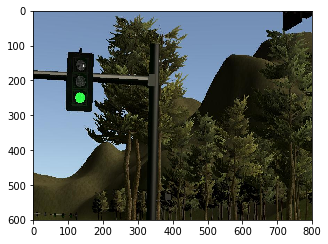

2.0 0


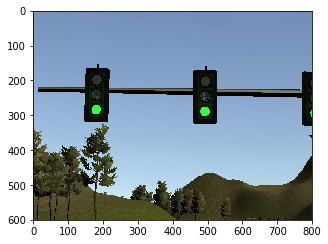

1.0 2


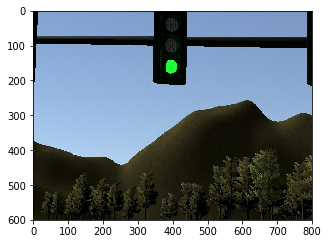

0.0 1


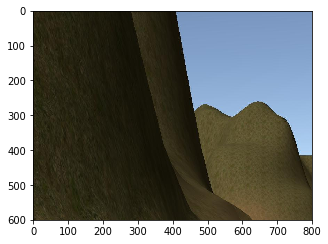

2.0 1


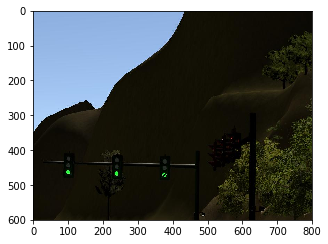

0.0 1


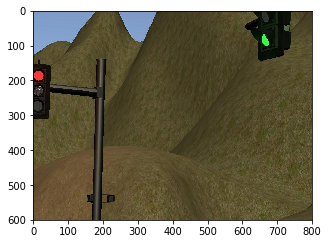

0.9375


In [8]:
def predict_test(sess, X_data, y_data):
    prediction = sess.run(tf.argmax(logits,1), feed_dict={x: X_data, y: y_data ,keep_prob : 1.0})
    return prediction
    
incorrect = 0
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in range(X_test.shape[0]):
        predictions = predict_test(sess, X_test[i:i+1], Y_test[i:i+1])
        if(predictions[0] != Y_test[i]):
            incorrect += 1
            print("Real = ", Class_names[int(Y_test[i])] , "Predicted = ", Class_names[predictions[0]])
            newimg2 = cv2.cvtColor(X_test[i], cv2.COLOR_RGB2BGR);
            plt.figure(figsize=(5,5))
            plt.imshow(newimg2)
            plt.show()
        
right_percent = 1.0 - incorrect / Y_test.shape[0]
print(right_percent)